In [1]:
import numpy as np
from matplotlib import pyplot as plt

the long-awaited power spectrum function

In [2]:
def P(T, r, Lsurvey, Npix):
    '''
    T = box of data for which you wish to create the power spectrum
    r = Npix-x-1 array where the ith element is the floor of the ith configuration space bin;
        except for the last bin, bins are shaped like [lo, hi) where the hi_{i}=lo_{i+1};
        last bin has bounds [lo, hi]
    Lsurvey = side length of the simulation cube
    Npix = number of bins per side of the simulation cube
    '''
    Delta = Lsurvey/Npix # voxel side length
    dr3 = Delta**3 # size of voxel
    twopi = 2*np.pi
    
    Ts = np.fft.ifftshift(T)*dr3 # T-ishifted (np wants a corner origin; ishift takes you there)
    Tts = np.fft.fftn(Ts) # T-tilde
    Tt = np.fft.fftshift(Tts) # shift back to physics land
    mTt = Tt*np.conjugate(Tt) # mod-squared of Tt # IMSHOW LOOKS GOOD
    
    Kshuf=twopi*np.fft.fftshift(np.fft.fftfreq(Lsurvey,d=Delta)) # fftshift not just for amplitudes
    kmags=np.empty((Lsurvey,Lsurvey,Lsurvey)) # magnitude of k (WRT cube center) for each pt in the simul cube
    for ii in range(Lsurvey):
        for jj in range(Lsurvey):
            for kk in range(Lsurvey):
                kmags[ii,jj,kk]=np.sqrt(Kshuf[ii]**2+Kshuf[jj]**2+Kshuf[kk]**2) # IMSHOW LOOKS GOOD and Hannah says things make sense up to here
    
    k = (twopi/(Lsurvey*r)) # should be Npix*Delta in the denom, but this is just Lsurvey
    binidxs=np.digitize(kmags,k,right=False) # IMSHOW LOOKS GOOD

    amTt=np.zeros(Npix,dtype='complex128')
    for i,binedge in enumerate(k):
        here=np.nonzero(i==binidxs) # WANT all box indices where the corresp bin index is the ith binedge (nonzero is like argwhere, but gives output that is suitable for indexing arrays)
        if (len(here[0])>0): # already know len(here) = arr_dimns, so check for emptiness w/ len(here[0])
            amTt[i]=np.mean(mTt[here])
        else:
            amTt[0]=0

    V = Lsurvey**3 # volume of the simulation cube
    return [np.array(k),np.array(amTt/V)]

white noise test

In [3]:
Lsurvey = 100
Npix = 20
r = np.logspace(-1,1.7,num=Npix) #10**1.7~50.118
T = np.random.normal(loc=0.0, scale=1.0, size=(Lsurvey,Lsurvey,Lsurvey))

kfloors,vals=P(T,r,Lsurvey,Npix)

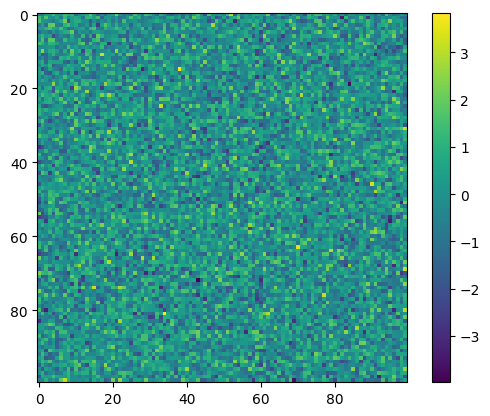

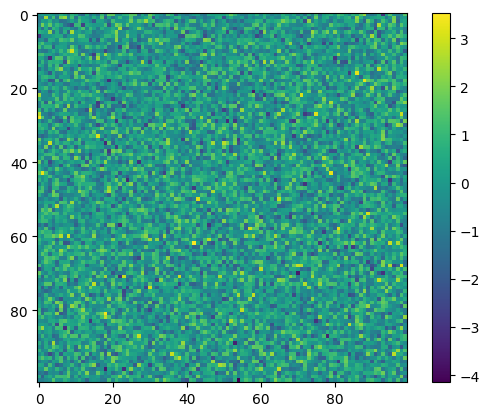

In [4]:
plt.imshow(T[:,:,5])
plt.colorbar()
plt.show()
plt.imshow(T[:,:,13])
plt.colorbar()
plt.show()

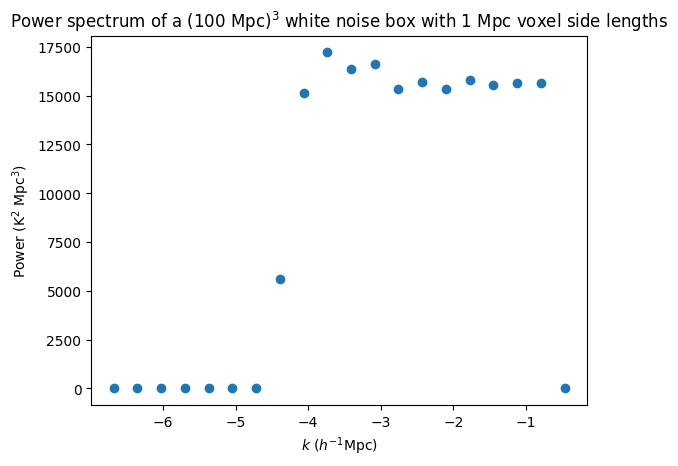

In [5]:
plt.scatter(np.log(kfloors),vals.real)
plt.xlabel('$k$ ($h^{-1}$Mpc)')
plt.ylabel('Power (K$^2$ Mpc$^3$)')
plt.title('Power spectrum of a (100 Mpc)$^3$ white noise box with 1 Mpc voxel side lengths')
plt.show()

In [6]:
# print(np.array([kfloors,vals]).T)
np.savetxt('ps_wn_20px.txt',np.array([kfloors,vals]).T)

This is just one realization. Technically, the power spectrum is only valid in the infinite ensemble average. But, we will develop an even better understanding of the current algorithm's performance by averaging over a handful (say, 10, to start with) of cases. This will be helpful towards deciding whether there are lingering mistakes in my implementation or whether the apparent fluctuations present in a given realization are merely due to cosmic variance. 

In [7]:
nrealizations=10
allps=np.zeros([Npix,nrealizations],dtype=complex)
for i in range(nrealizations):
    T = np.random.normal(loc=0.0, scale=1.0, size=(Lsurvey,Lsurvey,Lsurvey))
    kfls,values=P(T,r,Lsurvey,Npix) # don't bother storing kfl each time b/c passing the same r each time means that the vector of k floors will also be the same
    allps[:,i]=values

In [8]:
print(allps.shape)
meanps=np.mean(allps,axis=1)

(20, 10)


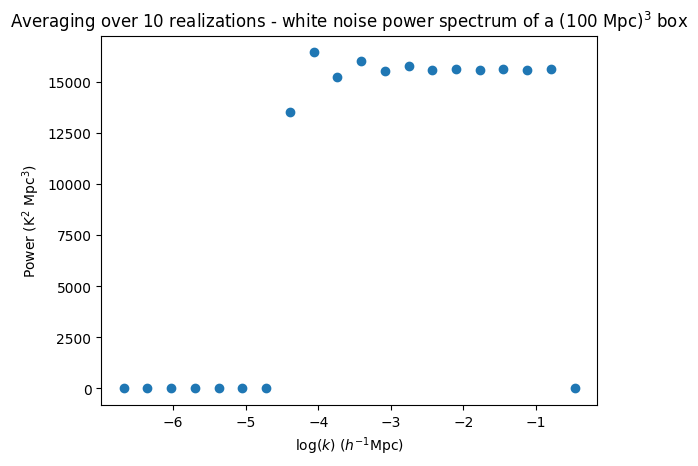

In [9]:
plt.scatter(np.log(kfls),meanps.real)
plt.xlabel('$\log(k)$ ($h^{-1}$Mpc)')
plt.ylabel('Power (K$^2$ Mpc$^3$)')
plt.title('Averaging over '+str(nrealizations)+' realizations - white noise power spectrum of a (100 Mpc)$^3$ box')
plt.show()
np.savetxt('meanps_10rz_20px.txt',meanps)

21cmFast example

In [10]:
zs=[5,6,7,8,9,10]
pstart='./sample_boxes_21cmfast/'
allzs21=[]

for z in zs:
    T21=np.load(pstart+'a_box_z_'+str(z)+'.npy')
    Lsurv21=100
    Nbins21=10
    r21 = np.logspace(-1,1.7,num=Nbins21)

    kfloors21,vals21=P(T21,r21,Lsurv21,Nbins21)
    allzs21.append([kfloors21,vals21])

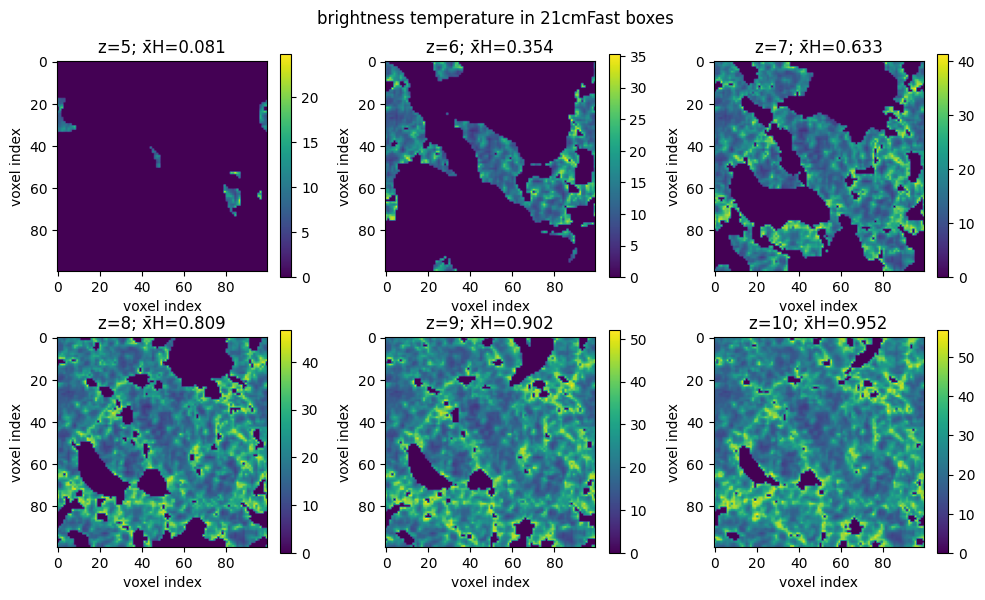

In [11]:
zs=['5','6','7','8','9','10']
xHs=[]
fig,axs=plt.subplots(2,3,figsize=(10,6))
i=0
j=0
for z in zs:
    box=np.load(pstart+'a_box_z_'+z+'.npy')
    xH=np.count_nonzero(box)/(100**3)
    xHs.append(xH)
    imcurr=axs[i][j].imshow(box[:,:,50])
    fig.colorbar(imcurr)
    axs[i][j].set_xlabel('voxel index')
    axs[i][j].set_ylabel('voxel index')
    axs[i][j].set_title('z='+str(z)+'; x̄H='+str(round(xH,3)))
    if (j==2):
        i=1
        j=0
    else:
        j+=1
    

fig.suptitle('brightness temperature in 21cmFast boxes')
fig.tight_layout()
plt.show()

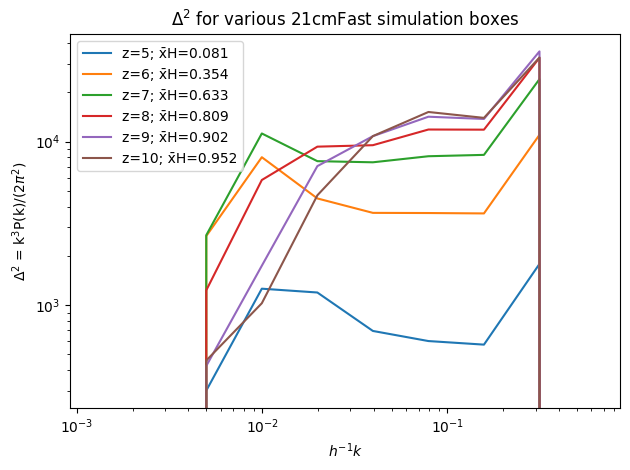

In [12]:
for i,z in enumerate(allzs21):
    kfloors21,vals21=z
    plt.loglog(kfloors21,kfloors21**3*vals21.real/(2*np.pi**2),label='z='+str(zs[i])+'; x̄H='+str(round(xHs[i],3)))

plt.xlabel('$h^{-1}k$')
plt.ylabel('$\Delta^2$ = k$^3$P(k)/(2$\pi^2$)')
plt.title('$\Delta^2$ for various 21cmFast simulation boxes')
plt.legend()
plt.tight_layout()
plt.show()